<a href="https://colab.research.google.com/github/guangyitan/face-mask-detector/blob/main/Train_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


# Import tools and libraries

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
# import tensorflow as tf
# from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
project_path = '/content/MyDrive/My Drive/Colab Notebooks/Soft Computing/'
training_zip_path = project_path + 'face-mask-detector.zip'
dataset_path = project_path + 'Datasets'

print(dataset_path)

/content/MyDrive/My Drive/Colab Notebooks/Soft Computing/Datasets


In [ ]:
# Initialize the path for dataset
imagePaths=list(paths.list_images(dataset_path))
print("Number of dataset:", len(imagePaths))

Number of dataset: 2878


In [ ]:
temp = imagePaths[-1]
print(temp)
print(len(imagePaths))

/content/MyDrive/My Drive/Colab Notebooks/Soft Computing/Datasets/No_Mask/00000/00999.png
2878


# Load and preprocess dataset

In [ ]:
# initialize dataset and its label
data=[]
labels=[]

for i in tqdm(imagePaths):

  # get the dataset label from its path
  label = i.split(os.path.sep)[-3]
  labels.append(label)

  # get the dataset image, convert to array and preprocess it
  image = load_img(i, target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)
  data.append(image)

100%|██████████| 2878/2878 [31:07<00:00,  1.54it/s]


In [ ]:
# do checking
print(len(labels))
print(len(data))

# data = np.array(data, dtype="float32")
# labels = np.array(labels)

2878
2878


In [ ]:
print(data.shape)
print(labels.shape)

AttributeError: ignored

In [ ]:
# print(data.shape)
# print(labels.shape)

(5795, 224, 224, 3)
(5795, 3)


In [ ]:
print(data.shape)
print(labels.shape)

(5795, 224, 224, 3)
(5795, 3, 2)


In [ ]:
# convert data and label to np array
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# labels = to_categorical(labels)

# split the data into 70% for training and 30% for testing 
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.30, stratify=labels, random_state=10)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
# check the shape of splited dataset
print("trainX:", trainX.shape)
print("testX:", testX.shape)
print("trainY:", trainY.shape)
print("testY:", testY.shape)

trainX: (2014, 224, 224, 3)
testX: (864, 224, 224, 3)
trainY: (2014, 3)
testY: (864, 3)


# Start Constructing the Model 

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the base model(MobileNetV2)
# I'm using softmax for multiclass classification 
# the output of model has 3 classes (mask, no_mask, wrong_mask)
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and set them as not trainable
for layer in baseModel.layers:
	layer.trainable = False

# check the architecture of the model
# Total params: 2,422,339
# Trainable params: 164,355 (from the layers that was added to the MobileNetV2)
# Non-trainable params: 2,257,984
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________

# Training the Model

In [ ]:
# initialize the learning rate, epochs and batch size to train the model
learning_rate = 0.001
epochs = 20
bs = 32

# initialize the optimizer 
optimizer = Adam(lr= learning_rate, decay=learning_rate/epochs)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

hist = model.fit(
    aug.flow(trainX, trainY, batch_size = bs),
    steps_per_epoch = len(trainX)//bs,
    validation_data = (testX, testY),
    validation_steps = len(testX)//bs,
    epochs = epochs
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
62/62 [==============================] - 52s 320ms/step - loss: 0.3896 - accuracy: 0.8502 - val_loss: 0.1417 - val_accuracy: 0.9491
Epoch 2/20
62/62 [==============================] - 19s 314ms/step - loss: 0.1501 - accuracy: 0.9445 - val_loss: 0.1029 - val_accuracy: 0.9572
Epoch 3/20
62/62 [==============================] - 20s 317ms/step - loss: 0.1137 - accuracy: 0.9571 - val_loss: 0.0907 - val_accuracy: 0.9676
Epoch 4/20
62/62 [==============================] - 20s 316ms/step - loss: 0.1062 - accuracy: 0.9637 - val_loss: 0.0817 - val_accuracy: 0.9711
Epoch 5/20
62/62 [==============================] - 19s 312ms/step - loss: 0.1084 - accuracy: 0.9647 - val_loss: 0.0857 - val_accuracy: 0.9664
Epoch 6/20
62/62 [==============================] - 19s 309ms/step - loss: 0.0893 - accuracy: 0.9702 - val_loss: 0.0813 - val_accuracy: 0.9688
Epoch 7/20
62/62 [==============================] - 19s 311ms/step - loss: 0.0733 - accuracy: 0.9738 - val_loss: 0.0913 - val_accuracy: 0.9722

In [ ]:
save_model_path = project_path + "/Saved_model"
save_weights_path = project_path +"/Saved_weights"

#Save the trained model
model.save(save_model_path) 

# Save the weights
model.save_weights(save_weights_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/MyDrive/My Drive/Colab Notebooks/Soft Computing//Saved_model/assets


In [ ]:
# backup the loss of the model
from google.colab import files
import json

with open('model_history.txt', 'w') as f:
    f.write(json.dumps(hist.history))
files.download('model_history.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

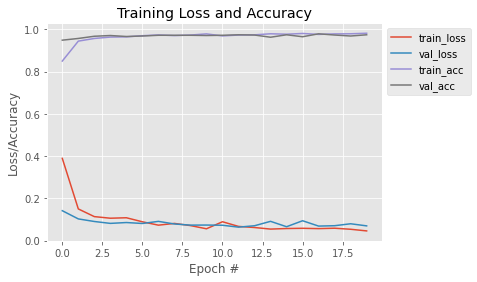

In [ ]:
# plot the training loss and accuracy graphs of training and validation 
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(bbox_to_anchor=(1, 1))

In [ ]:
predict = model.predict(testX, batch_size = bs)

predict = np.argmax(predict,axis=1)
print(classification_report(testY.argmax(axis=1), predict, target_names=lb.classes_))

                precision    recall  f1-score   support

Incorrect_Mask       0.94      0.98      0.96       279
          Mask       0.99      0.94      0.96       285
       No_Mask       1.00      1.00      1.00       300

      accuracy                           0.97       864
     macro avg       0.97      0.97      0.97       864
  weighted avg       0.98      0.97      0.97       864



In [ ]:
# # To load the model
new_model = load_model('/content/MyDrive/My Drive/Colab Notebooks/Soft Computing/Saved_model')

In [ ]:
hist.history

{'accuracy': [0.8501513600349426,
  0.9445005059242249,
  0.957114040851593,
  0.9636730551719666,
  0.9646821618080139,
  0.9702320694923401,
  0.9737638831138611,
  0.9707366228103638,
  0.9732593297958374,
  0.9788092970848083,
  0.9692230224609375,
  0.9732593297958374,
  0.9742684364318848,
  0.979313850402832,
  0.9772956371307373,
  0.9808274507522583,
  0.9762865900993347,
  0.9788092970848083,
  0.979313850402832,
  0.9818365573883057],
 'loss': [0.3895569443702698,
  0.15013709664344788,
  0.11374998092651367,
  0.10618852078914642,
  0.10837184637784958,
  0.08928857743740082,
  0.07329221814870834,
  0.0815257579088211,
  0.07129303365945816,
  0.05615605413913727,
  0.08946371078491211,
  0.06738469004631042,
  0.06214471533894539,
  0.05473016947507858,
  0.05739656090736389,
  0.05844041332602501,
  0.05689486488699913,
  0.05881491303443909,
  0.05389240011572838,
  0.04606708511710167],
 'val_accuracy': [0.9490740895271301,
  0.9571759104728699,
  0.9675925970077515,
 

In [ ]:
new_model.history["loss"]

TypeError: ignored

# Draft



In [ ]:
# function ClickConnect(){
#     console.log("Clicked on connect button"); 
#     document.querySelector("colab-connect-button").click()
# }
# setInterval(ClickConnect,60000)